In [3]:
# https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10


from tqdm import tqdm
import time
import copy
import numpy as np
from colorama import Fore, Back, Style
import imgaug.augmenters as iaa

from autoencoder import Encoder, Decoder, Autoencoder
from train import train_loop, test_loop, plotTraining

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0

DATASET_PATH = 'dataset/CIFAR10/'
WEIGHTS_PATH = 'wts/'
deviceGpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_test_images(num):
    return torch.stack([test_set[i][0] for i in range(num)], dim=0)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/Anaconda3-2021.11-Linux-x86_64/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# latent_dim in [64, 128, 256, 384]
base_channel_size= 32
latent_dim = 128

# load the trained decoder
encoder = Encoder(3, base_channel_size, latent_dim) # 3-->32-->128
encoder.load_state_dict(torch.load(WEIGHTS_PATH+'Encoder.pth'))
encoder = encoder.to(deviceGpu)

encoderA = Encoder(3, base_channel_size, latent_dim)
encoderA.load_state_dict(torch.load(WEIGHTS_PATH+'EncoderA.pth'))
encoderA = encoderA.to(deviceGpu)

encoderB = Encoder(3, base_channel_size, latent_dim)
encoderB.load_state_dict(torch.load(WEIGHTS_PATH+'EncoderB.pth'))
encoderB = encoderB.to(deviceGpu)

In [6]:
# load the trained autoencoder
mymodel = Autoencoder(base_channel_size, latent_dim)
mymodel.load_state_dict(torch.load(WEIGHTS_PATH+'Autoencoder.pth'))
mymodel = mymodel.to(deviceGpu)

myencoder = mymodel.encoder
mydecoder = mymodel.decoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32])


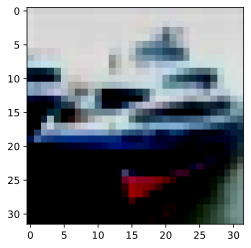

In [7]:
oneImg = test_set[1][0].view(-1,3,32,32).to(deviceGpu)
plt.imshow(test_set[1][0].permute(1, 2, 0))

print(oneImg.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU()
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): GELU()
    )
    (net): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): GELU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

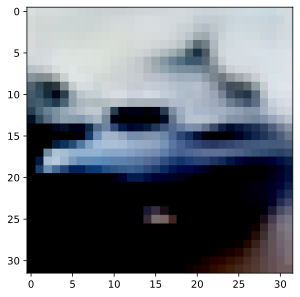

In [6]:
outputImg = mymodel(oneImg)
print(mymodel)
# outputImg.view(3,32,32).permute(1, 2, 0).shape
plt.imshow(outputImg.view(3,32,32).permute(1, 2, 0).cpu().detach().numpy())

print(outputImg.shape, oneImg.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


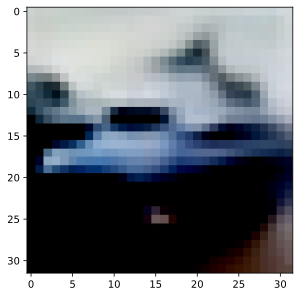

In [6]:
latentV = myencoder(oneImg)
latentV[0,116] = 0
outputImg1 = mydecoder(latentV)
plt.imshow(outputImg1.view(3,32,32).permute(1, 2, 0).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


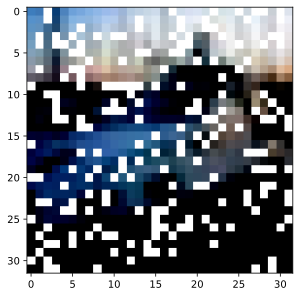

In [8]:
img = test_set[2][0].permute(1, 2, 0).detach().numpy()
# aug = iaa.Cutout(nb_iterations=20)
aug = iaa.Salt(0.2)
image_aug= aug(image = img)
oneImag = torch.tensor(image_aug).permute(2, 0, 1)

plt.imshow(image_aug)

In [9]:
arr2d_M = []
arr2d_Std = []
for j in tqdm(range(10), desc='Processing items', unit='iteration'):
    
    # aug = iaa.Cutout(nb_iterations=j)
    aug = iaa.Salt(j/10)

    arrM = []
    arrStd = []
    for i in range(10):
        img = test_set[i][0].permute(1, 2, 0).detach().numpy()
        image_aug= aug(image = img)
        oneImg = torch.tensor(image_aug).permute(2, 0, 1).view(-1,3,32,32).to(deviceGpu)

        latentV = encoder(oneImg)
        latentVA = encoderA(oneImg)
        latentVB = encoderB(oneImg)
        
        
        # print(latentV.shape) [1, 128]

        latentV_T = torch.stack((latentV,latentVA,latentVB), dim=1).view(3,latent_dim)
        latentV_M = latentV_T.mean(dim=0)
        latentV_Std = latentV_T.std(dim=0)

        # print(latentV_Std.shape) [128]
        
        arrM.append(latentV_M)
        arrStd.append(latentV_Std)

        # arrM.append(latentV_M.sum())
        # arrStd.append(latentV_Std.sum())

    arrM = torch.stack(arrM).mean(dim=0)
    arrStd = torch.stack(arrStd).mean(dim=0)
    
    arr2d_M.append(arrM)
    arr2d_Std.append(arrStd)

arr2d_M = torch.stack(arr2d_M)
arr2d_Std = torch.stack(arr2d_Std)

Processing items: 100%|██████████| 10/10 [00:00<00:00, 28.11iteration/s]


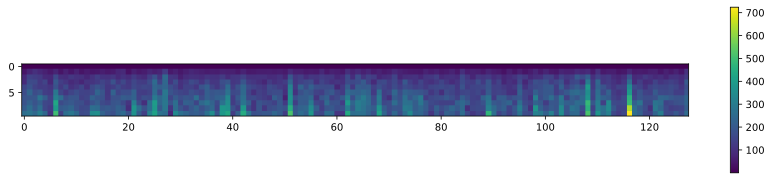

In [11]:
plt.figure(figsize = (15,3))
plt.imshow(arr2d_Std.cpu().detach().numpy())
plt.colorbar()

In [21]:
print(arr2d_M.shape)
print(arr2d_Std.shape)

torch.Size([10, 128])
torch.Size([10, 128])


In [11]:
arrM.shape

torch.Size([128])

In [12]:
arr6 = arrStd.cpu().detach().numpy()

In [13]:
plt.plot(arr0, label='0')
plt.plot(arr1, label='1')
plt.plot(arr2, label='2')
plt.plot(arr3, label='3')
plt.plot(arr4, label='4')
plt.legend()

NameError: name 'arr0' is not defined

In [14]:
plt.plot(np.stack((arr1,arr1,arr3,arr4,arr5,arr6), axis=1))
plt.legend()

NameError: name 'arr1' is not defined

In [15]:
arrM = []
arrStd = []
for i in tqdm(range(10), desc='Processing items', unit='iteration'):
    oneImg = test_set[i][0].view(-1,3,32,32).to(deviceGpu)

    latentV = encoder(oneImg)
    latentVA = encoderA(oneImg)
    latentVB = encoderB(oneImg)
    
    latentV_T = torch.stack((latentV,latentVA,latentVB), dim=1).view(3,latent_dim)
    latentV_M = latentV_T.mean(dim=0)
    latentV_Std = latentV_T.std(dim=0)
    
    arrM.append(latentV_M.sum())
    arrStd.append(latentV_Std.sum())

arrM = torch.tensor(arrM)
arrStd = torch.tensor(arrStd)
print(arrStd)

Processing items: 100%|██████████| 10/10 [00:00<00:00, 333.81iteration/s]

tensor([2.6142, 3.3860, 1.5860, 2.0709, 1.9186, 1.7825, 4.3660, 1.5021, 1.5891,
        2.4462])


In [16]:
arrM_10 = []
arrStd_10 = []
for i in tqdm(range(10), desc='Processing items', unit='iteration'):
    img = test_set[i][0].permute(1, 2, 0).detach().numpy()
    aug = iaa.Cutout(nb_iterations=10)
    image_aug= aug(image = img)
    oneImag = torch.tensor(image_aug).permute(2, 0, 1).view(-1,3,32,32).to(deviceGpu)

    latentV = encoder(oneImg)
    latentVA = encoderA(oneImg)
    latentVB = encoderB(oneImg)
    
    latentV_T = torch.stack((latentV,latentVA,latentVB), dim=1).view(3,latent_dim)
    latentV_M = latentV_T.mean(dim=0)
    latentV_Std = latentV_T.std(dim=0)
    
    arrM_10.append(latentV_M.sum())
    arrStd_10.append(latentV_Std.sum())

arrM_10 = torch.tensor(arrM_10)
arrStd_10 = torch.tensor(arrStd_10)
print(arrStd_10)

Processing items: 100%|██████████| 10/10 [00:00<00:00, 269.48iteration/s]

tensor([2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462,
        2.4462])


In [18]:
arrM_15 = []
arrStd_15 = []
for i in tqdm(range(10), desc='Processing items', unit='iteration'):
    img = test_set[i][0].permute(1, 2, 0).detach().numpy()
    aug = iaa.Cutout(nb_iterations=15)
    image_aug= aug(image = img)
    oneImag = torch.tensor(image_aug).permute(2, 0, 1).view(-1,3,32,32).to(deviceGpu)

    latentV = encoder(oneImg)
    latentVA = encoderA(oneImg)
    latentVB = encoderB(oneImg)
    
    latentV_T = torch.stack((latentV,latentVA,latentVB), dim=1).view(3,latent_dim)
    latentV_M = latentV_T.mean(dim=0)
    latentV_Std = latentV_T.std(dim=0)
    
    arrM_15.append(latentV_M.sum())
    arrStd_15.append(latentV_Std.sum())

arrM_15 = torch.tensor(arrM_15)
arrStd_15 = torch.tensor(arrStd_15)
print(arrStd_15)

Processing items: 100%|██████████| 10/10 [00:00<00:00, 428.83iteration/s]

tensor([2.4467, 2.4467, 2.4467, 2.4467, 2.4467, 2.4467, 2.4467, 2.4467, 2.4467,
        2.4467])


In [17]:
arrM_20 = []
arrStd_20 = []
for i in tqdm(range(10), desc='Processing items', unit='iteration'):
    img = test_set[i][0].permute(1, 2, 0).detach().numpy()
    aug = iaa.Cutout(nb_iterations=20)
    image_aug= aug(image = img)
    oneImag = torch.tensor(image_aug).permute(2, 0, 1).view(-1,3,32,32).to(deviceGpu)

    latentV = encoder(oneImg)
    latentVA = encoderA(oneImg)
    latentVB = encoderB(oneImg)
    
    latentV_T = torch.stack((latentV,latentVA,latentVB), dim=1).view(3,latent_dim)
    latentV_M = latentV_T.mean(dim=0)
    latentV_Std = latentV_T.std(dim=0)
    
    arrM_20.append(latentV_M.sum())
    arrStd_20.append(latentV_Std.sum())

arrM_20 = torch.tensor(arrM_20)
arrStd_20 = torch.tensor(arrStd_20)
print(arrStd_20)

Processing items: 100%|██████████| 10/10 [00:00<00:00, 248.82iteration/s]

tensor([2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462,
        2.4462])


In [97]:
oneImag.shape

torch.Size([3, 32, 32])

In [92]:
print(torch.tensor(image_aug).shape)

torch.Size([32, 32, 3])


In [111]:
print(arrStd_5)

tensor([2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462, 2.4462,
        2.4462])


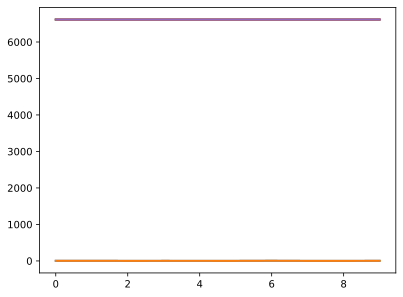

In [138]:
arr1 = arrStd.cpu().detach().numpy()
arr2 = arrStd_5.cpu().detach().numpy()
arr3 = arrStd_10.cpu().detach().numpy()
arr4 = arrStd_15.cpu().detach().numpy()
arr5 = arrStd_20.cpu().detach().numpy()
plt.plot(np.stack((arr1,arr1,arr3,arr4,arr5), axis=1))

In [139]:
print(arr1)

[2.6141534 3.3859625 1.5859785 2.0708652 1.9185874 1.7824743 4.366001
 1.5021433 1.5891364 2.4462042]


In [140]:
print(arr2)

[8532.666  9629.148  7773.4478 6958.8125 6941.253  7311.001  6522.325
 8050.232  8449.683  6616.283 ]


In [141]:
print(arr3)

[6616.283 6616.283 6616.283 6616.283 6616.283 6616.283 6616.283 6616.283
 6616.283 6616.283]


In [142]:
print(arr4)

[6616.283 6616.283 6616.283 6616.283 6616.283 6616.283 6616.283 6616.283
 6616.283 6616.283]


In [49]:
latentV_T = torch.stack((latentV,latentVA,latentVB), dim=1).view(3,latent_dim)
latentV_M = latentV_T.mean(dim=0)
latentV_Std = latentV_T.std(dim=0)
print(latentV_M.sum(), latentV_Std.sum())

tensor(-2.1358, device='cuda:0', grad_fn=<SumBackward0>) tensor(2.0709, device='cuda:0', grad_fn=<SumBackward0>)


In [40]:
tensor1 = torch.rand(1,5)
print(tensor1)
tensor2 = torch.rand(1,5)
print(tensor2)
tensor3 = torch.rand(1,5)
print(tensor3)

tensor_T = torch.stack((tensor1,tensor2,tensor3), dim=1).view(3,5)
print(tensor_T)

print(tensor_T.mean(dim=0))
print(tensor_T.std(dim=0))

tensor([[0.1288, 0.0077, 0.3748, 0.9800, 0.8828]])
tensor([[0.8547, 0.9529, 0.7609, 0.8745, 0.4901]])
tensor([[0.3662, 0.4118, 0.6337, 0.6076, 0.6879]])
tensor([[0.1288, 0.0077, 0.3748, 0.9800, 0.8828],
        [0.8547, 0.9529, 0.7609, 0.8745, 0.4901],
        [0.3662, 0.4118, 0.6337, 0.6076, 0.6879]])
tensor([0.4499, 0.4575, 0.5898, 0.8207, 0.6869])
tensor([0.3701, 0.4743, 0.1968, 0.1920, 0.1964])


In [38]:
(0.3063+0.7624+0.8383)/3

0.6356666666666667

In [15]:
arr1 = latentVB.cpu().detach().numpy()
arr2 = latentV.cpu().detach().numpy()

np.testing.assert_allclose(arr1, arr2, rtol=1e-03, atol=1e-05)

AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 126 / 128 (98.4%)
Max absolute difference: 0.09464645
Max relative difference: 14.865755
 x: array([[-0.257586,  0.115968, -0.305464, -0.062669, -0.288213, -0.290113,
        -0.061201, -0.243509,  0.309217, -0.071895,  0.280118,  0.054616,
        -0.19555 ,  0.032879, -0.627885,  0.455697,  0.138114, -0.500699,...
 y: array([[-0.237597,  0.084074, -0.278115, -0.023084, -0.303913, -0.217179,
        -0.050356, -0.227953,  0.359913, -0.055663,  0.237976,  0.053013,
        -0.205341,  0.038708, -0.66483 ,  0.389229,  0.076141, -0.505171,...